# Build your own Fitbit App

Data is cool, but what is cooler than looking at other people's data? Looking at your own Data! In this project we will construct our own miniature app that uses the Fitbit API to pull our own data. If you don't own a Fitbit, don't worry! You can download the free Fitbit app for iOS or Android and it will still log your steps using the accelorometer in your phone. Having a Fitbit device is slightly more exciting: it will log your sleep and heart rate as well (if you have a heart rate enabled device).

# Step I: Register your own app

There is a bit of setup that you will need to go through before you can actually pull your own data. Fitbit requires you to register an app in order to do this. In order to do this you will need to create a Fitbit account, and then follow the instructions found in [step 1 of this article](https://towardsdatascience.com/collect-your-own-fitbit-data-with-python-ff145fa10873).

# Step 2: Authenticate using our OAuth token
Now that we have a personal app that supplies us with a OAuth credentials we can authenticate and pull our data from Fitbit using our app. In order to do this we'll use some external libraries. Note that you will probably want to run this notebook locally (e.g. not on the jupyter hub instance) since an authentication tab will open up in your browser, and if you are working remotely it may not foward correctly.

In [26]:
# Required packages
import fitbit
import utils.gather_keys_oauth2 as Oauth2
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt

In [27]:
%matplotlib inline

In [2]:
########################################################################################################
# YOU SHOULD SET YOUR FITBIT CLIENT ID AND SECRET AS ENVIRONMENT VARIABLES RATHER THAN PLACING THEM AS #
# RAW TEXT IN YOUR SCRIPT. ANYONE WHO VIEWS YOUR CREDENTIALS CAN PULL YOUR DATA.                       #
########################################################################################################
CLIENT_ID = os.environ['FITBIT_CLIENT_ID']
CLIENT_SECRET = os.environ['FITBIT_CLIENT_SECRET']

In [5]:
server = Oauth2.OAuth2Server(CLIENT_ID, CLIENT_SECRET) # Instantiate OAuth server
server.browser_authorize() # Request to be authorized via OAuth
ACCESS_TOKEN = str(server.fitbit.client.session.token['access_token']) # Save access token
REFRESH_TOKEN = str(server.fitbit.client.session.token['refresh_token']) # Save refresh token

# Instantiate connection
auth2_client = fitbit.Fitbit(
    CLIENT_ID,
    CLIENT_SECRET,
    oauth2=True,
    access_token=ACCESS_TOKEN,
    refresh_token=REFRESH_TOKEN
)

[10/Apr/2018:14:41:13] ENGINE Listening for SIGTERM.
[10/Apr/2018:14:41:13] ENGINE Listening for SIGHUP.
[10/Apr/2018:14:41:13] ENGINE Listening for SIGUSR1.
[10/Apr/2018:14:41:13] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[10/Apr/2018:14:41:13] ENGINE Started monitor thread 'Autoreloader'.
[10/Apr/2018:14:41:14] ENGINE Serving on http://127.0.0.1:8080
[10/Apr/2018:14:41:14] ENGINE Bus STARTED


127.0.0.1 - - [10/Apr/2018:14:41:15] "GET /?code=33fbd7538a4f31770b76ca17c6992aee97d2e00a&state=GSiG176J03IkNquMXxDktwYpdsVWhG HTTP/1.1" 200 122 "" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3325.181 Safari/537.36"


[10/Apr/2018:14:41:16] ENGINE Bus STOPPING
[10/Apr/2018:14:41:21] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[10/Apr/2018:14:41:21] ENGINE Stopped thread 'Autoreloader'.
[10/Apr/2018:14:41:21] ENGINE Bus STOPPED
[10/Apr/2018:14:41:21] ENGINE Bus EXITING
[10/Apr/2018:14:41:21] ENGINE Bus EXITED
[10/Apr/2018:14:41:21] ENGINE Waiting for child threads to terminate...


# Pull our Data

Voile! We have a working connection to our app that allows us to pull our Fitbit data! Our next step is to take the raw response and parse it into the our standard data analysis object- a pandas dataframe. In this section we will pull the steps data. If you have a Fitbit device you can also pull sleep and heart rate data from the api.

In [21]:
def pull_date_activity(connection, date_string, endpoint='activities/steps'):
    """
    Pull activity from an endpoint for a given day
    
    Inputs:
        connection: Connection to your Fitbit app
        endpoint: API endpoint you want to pull data from
        date_string: Date string of the form "yyyy-mm-dd"
    Returns:
        Pandas DataFrame of values for requested activity for the requested date
    """
    result_set = connection.intraday_time_series(
        endpoint,
        base_date=date_string
    )
    
    act_type = endpoint.split('/')[1]
    get_key = f'activities-{act_type}-intraday'
    df = pd.DataFrame.from_dict(result_set[get_key]['dataset'])
    df['timestamp'] = date_string + ' ' + df['time']
    df['timestamp'] = pd.to_datetime(df.timestamp)
    df.drop(columns='time', inplace=True)
    df.set_index('timestamp', inplace=True)
    return df
    

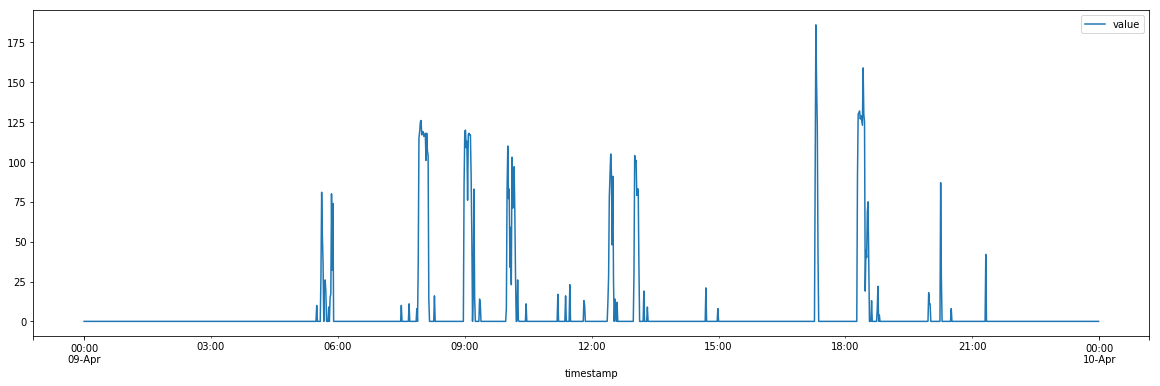

In [30]:
pull_date_activity(auth2_client, '2018-04-09').plot(figsize=(20, 6))

Nice! Now I have my fitbit data for a specific day, and can start tracking my own behavior patterns. One thing that immediately stands out is how little I walk throughout the day, that's something I'll need to improve!

# Exercises

The following exercises are designed to help get your creative juices flowing and expose you to some of the kinds of questions you can answer using this tpe of data.